# 逻辑回归


In [52]:
import torch
from torch import nn
from torch.nn import init
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE' # plt绘图报错（不显示图的问题）
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [53]:
mnist_train = torchvision.datasets.FashionMNIST(root='F:/bigdata/ai/Pytorch_Datasets',
                                                train=True,
                                                download=True,
                                                transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='F:/bigdata/ai/Pytorch_Datasets',
                                               train=False,
                                               download=True,
                                               transform=transforms.ToTensor())
# 会在指定目录下自动创建FashionMNIST文件夹（目录后面不要加/）

def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt（T恤）', 'trouser（裤子）', 'pullover（套衫）', 'dress（连衣裙）', 'coat（外套）',
                   'sandal（凉鞋）', 'shirt（衬衫）', 'sneaker（运动鞋）', 'bag（包）', 'ankle boot（短靴）']
    return [text_labels[int(i)] for i in labels]

# len(images) >= 2
def show_fashion_mnist(images, labels):
    # 这里的_表示我们忽略（不使用）的变量
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()
# 计算准确率
def evaluate_accuracy(test_data_iter, model):
    acc_sum, n = 0.0, 0
    for X, y in test_data_iter:
        acc_sum += (model(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

torch.Size([1, 28, 28])


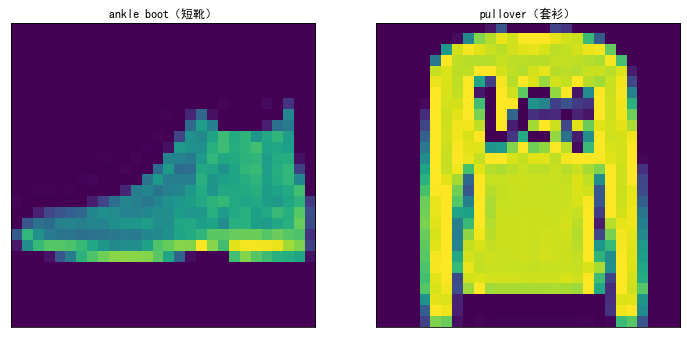

In [54]:
print(mnist_test[0][0].size()) #(1,28,28)

show_fashion_mnist([mnist_test[0][0],mnist_test[1][0]], get_fashion_mnist_labels([mnist_test[0][1],mnist_test[1][1]]))

In [55]:
num_inputs = 784
num_outputs = 10

class LogisticRegression(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_inputs, num_outputs)
        )
        # self.linear = nn.Linear(num_inputs, num_outputs)
    def forward(self, x): # x shape: (batch, 1, 28, 28)
        # y = self.linear(x.view(x.shape[0], -1))
        y = self.linear(x)
        # y = torch.softmax(y,dim=1) #不需要，加了效果反而不好
        return y

model = LogisticRegression(num_inputs, num_outputs)
init.normal_(model.linear[1].weight, mean=0, std=0.01)
init.constant_(model.linear[1].bias, val=0)

# nn.CrossEntropyLoss()中的label不需要是one_hot。要求是一维的label。
# 在使用该函数前 input不需要经过softmax计算， target不是one_hot编码格式
loss = nn.CrossEntropyLoss() 

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)


In [56]:
batch_size = 256

# Create data loaders.
train_dataloader = DataLoader(mnist_train, batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(mnist_test, batch_size=batch_size)

num_epochs = 10
for epoch in range(1, num_epochs + 1):
    model.train()
    for X, y in train_dataloader:
        # 计算预测误差
        output = model(X)
        # y = torch.nn.functional.one_hot(y,10) # 不需要
        l = loss(output, y)

        # 反向传播
        optimizer.zero_grad() # 梯度清零，等价于net.zero_grad()
        l.backward()
        optimizer.step()
    model.eval()
    print('epoch %d, loss: %f, acc: %f' % (epoch, l.item() , evaluate_accuracy(test_dataloader,model)))

epoch 1, loss: 0.560904, acc: 0.786200
epoch 2, loss: 0.491178, acc: 0.811400
epoch 3, loss: 0.463886, acc: 0.819500
epoch 4, loss: 0.447283, acc: 0.825000
epoch 5, loss: 0.435161, acc: 0.826800
epoch 6, loss: 0.425506, acc: 0.829100
epoch 7, loss: 0.417439, acc: 0.832200
epoch 8, loss: 0.410499, acc: 0.833700
epoch 9, loss: 0.404409, acc: 0.835100
epoch 10, loss: 0.398988, acc: 0.835800


In [57]:
for i in range(20):
    #print(np.argmax(model(mnist_test[i][0]).detach().numpy()) ,"---实际：", mnist_test[i][1] )
    print(model(mnist_test[i][0]).argmax(dim=1) ,"---实际：", mnist_test[i][1] )

tensor([9]) ---实际： 9
tensor([2]) ---实际： 2
tensor([1]) ---实际： 1
tensor([1]) ---实际： 1
tensor([6]) ---实际： 6
tensor([1]) ---实际： 1
tensor([4]) ---实际： 4
tensor([6]) ---实际： 6
tensor([5]) ---实际： 5
tensor([7]) ---实际： 7
tensor([4]) ---实际： 4
tensor([5]) ---实际： 5
tensor([5]) ---实际： 7
tensor([3]) ---实际： 3
tensor([4]) ---实际： 4
tensor([1]) ---实际： 1
tensor([2]) ---实际： 2
tensor([4]) ---实际： 4
tensor([8]) ---实际： 8
tensor([0]) ---实际： 0


# 传统的逻辑回归(二分类)
定义模型
```
class LR(nn.Module):
    def __init__(self):
        super(LR,self).__init__()
        self.fc=nn.Linear(24,2) # 由于24个维度已经固定了，所以这里写24
    def forward(self,x):
        out=self.fc(x)
        out=torch.sigmoid(out)
        return out
```
测试集上的准确率
```
def test(pred,lab):
    t=pred.max(-1)[1]==lab
    return torch.mean(t.float())
```

```
net=LR()
criterion=nn.CrossEntropyLoss() # 使用CrossEntropyLoss损失
optm=torch.optim.Adam(net.parameters()) # Adam优化
epochs=1000 # 训练1000次
# test_lab 属于{0,1}

for i in range(epochs):
    # 指定模型为训练模式，计算梯度
    net.train()
    # 输入值都需要转化成torch的Tensor(这里是做一次全量的，没有分batch)
    x=torch.from_numpy(train_data).float()
    y=torch.from_numpy(train_lab).long()
    y_hat=net(x)
    loss=criterion(y_hat,y) # 计算损失
    optm.zero_grad() # 前一步的损失清零
    loss.backward() # 反向传播
    optm.step() # 优化
    if (i+1)%100 ==0 : # 这里我们每100次输出相关的信息
        # 指定模型为计算模式
        net.eval()
        test_in=torch.from_numpy(test_data).float()
        test_l=torch.from_numpy(test_lab).long()
        test_out=net(test_in)
        # 使用我们的测试函数计算准确率
        accu=test(test_out,test_l)
        print("Epoch:{},Loss:{:.4f},Accuracy：{:.2f}".format(i+1,loss.item(),accu))
```

# 如果说自己实现（多分类）
```
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(dim=1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

def net(X):
    return softmax(torch.mm(X.view((-1, num_inputs)), W) + b)

# 交叉熵损失函数
def cross_entropy(y_hat, y):
    return - torch.log(y_hat.gather(1, y.view(-1, 1)))

# 分类准确率
def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1) == y).float().mean().item()

# 评价模型net在数据集data_iter上的准确率
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n
```
训练模型

```
num_epochs, lr = 5, 0.1

def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
              params=None, lr=None, optimizer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()

            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()

            l.backward()
            if optimizer is None:
                d2l.sgd(params, lr, batch_size)
            else:
                optimizer.step()  # “softmax回归的简洁实现”一节将用到


            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W, b], lr)
```